<h2>Análise de traços de execução</h2>

<h3>Installs de bibliotecas necessárias</h3>

In [2]:
%pip install findspark pyspark_dist_explore pyspark plotly pandas chart-studio

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\322010\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


<h4>Primeiro utilizamos o findspark para que o ambiente saiba onde o spark está localizado.</h4>

In [3]:
import findspark

In [4]:
findspark.init()

<h4>Imports(têm de ser feitos após o init do findspark)</h4>

In [19]:
import pyspark
from pyspark_dist_explore import hist
import time
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import math
import sys,os
from pyspark.sql import SparkSession
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.types import StructType,StructField, LongType, IntegerType,FloatType

<h4>Inicializamos uma seção Spark, ou pegamos a que está atualmente em execução</h4>

In [6]:
spark=SparkSession.builder.appName("Sessao").getOrCreate()

In [7]:
sc = spark.sparkContext

<h4>Definimos um schema para o RDD</h4>

In [8]:
instance_events_schema = StructType([ \
    StructField("time",LongType(),True), \
    StructField("type",IntegerType(),True), \
    StructField("collection_id",IntegerType(),False), \
    StructField("priority", IntegerType(), True), \
    StructField("instance_index", IntegerType(), False), \
    StructField("resource_request.cpus", FloatType(), True), \
    StructField("resource_request.memory", FloatType(), True) \
  ])

<h4>Carregamos um arquivo CSV em um RDD(sem cabeçalho e com o schema definido)</h4>

In [9]:
rddCE = spark.read.option("header","true").schema(instance_events_schema).csv("instance_events/instance_events-000000000005.csv")

<h4>Média dos requerimentos de utilização de memória(por tipo de "coisa")</h4>

<p>Ao persistir o RDD, operações subsequentes reutilizarão os dados relativos ao RDD em operações que o envolvam, diminuindo drasticamente o tempo de execução das mesmas</p>

In [10]:
rddCE.persist()

DataFrame[time: bigint, type: int, collection_id: int, priority: int, instance_index: int, resource_request.cpus: float, resource_request.memory: float]

<p>Essa é executada sem cache</p>

In [10]:
rddCE.orderBy('type').groupBy('type').agg({"`memory_resource_request`":'avg'}).show()

+----+----------------------------+
|type|avg(memory_resource_request)|
+----+----------------------------+
|   0|        0.003215060709829252|
|   1|         0.01933770519928046|
|   2|        0.003345685608592...|
|   3|        0.003335462585395...|
|   4|        0.003473938670384...|
|   5|        0.020445465992991966|
|   6|        0.004764337917852076|
|   7|        0.002935408097730315|
|   8|        0.005776905272776365|
|   9|        0.003988534368734...|
|  10|        0.008756889907134162|
+----+----------------------------+



<p>Essa é executada COM cache</p>

In [11]:
rddCE.orderBy('type').groupBy('type').agg({"`cpu_resource_request`":'avg'}).show()

+----+-------------------------+
|type|avg(cpu_resource_request)|
+----+-------------------------+
|   0|     0.009525861089444346|
|   1|     0.009540171341634771|
|   2|     0.009649705901209166|
|   3|     0.009805624388920475|
|   4|     0.009645259130290452|
|   5|     0.008741734786721873|
|   6|     0.014509926217036775|
|   7|     0.009677616500338168|
|   8|     0.018229468438387228|
|   9|     0.013241837398293013|
|  10|     0.011053578572176771|
+----+-------------------------+



<h4>filtra os eventos de tasks com tipo=3(submissão), com valores de tempo dentro do intervalo observado no traço (0<t<MAXINT>>)</h4>

In [40]:
rddCE = rddCE.filter((rddCE.time.isNotNull()) & (rddCE.type==3) & (rddCE.time>0) & (rddCE.time<sys.maxsize))

Converte microssegundo em hora:

In [11]:
def microToHour(x):
    return math.floor(x/3.6e+9)

Define o objeto udf, que pode ser utilizado pra aplicar a função microToHour no RDD

In [12]:
udf_hours = F.udf(lambda x:microToHour(x),IntegerType())

cria-se nova coluna com o tempo em horas e adiciona-a ao RDD

In [13]:
rddWithH1 = rddCE.withColumn("hour",udf_hours(col("time")))

In [14]:
rddWithH1 = rddWithH1.filter((rddWithH1.time.isNotNull()) & (rddWithH1.time>0) & (rddWithH1.time<sys.maxsize))

Acha as máximas e mínimas das horas

In [25]:
maxTime = rddCE.agg({'time':'max'}).collect()[0][0]
minTime = rddCE.agg({'time':'min'}).collect()[0][0]
maxTime,minTime

(604799625804, 600777673)

In [27]:
rddCE.agg({'time':'count'}).collect()[0][0]/(microToHour(maxTime)-microToHour(minTime))

11904.419161676647

Encontra a quantidade de tasks submetidas por hora, ao iterar por todos os arquivos

In [34]:
minTime = sys.maxsize
maxTime = 0
type3Count = 0
for filename in os.listdir("instance_events"):
    f = os.path.join("instance_events",filename)
    rddCE = spark.read.option("header","true").schema(instance_events_schema).csv(f)
    rddCE.persist()
    rddCE = rddCE.filter((rddCE.time.isNotNull()) & (rddCE.type==3) & (rddCE.time>0) & (rddCE.time<sys.maxsize))
    type3Count = type3Count+rddCE.agg({'time':'count'}).collect()[0][0]
    if rddCE.agg({'time':'count'}).collect()[0][0]>0:
        maxTime = max(maxTime,rddCE.agg({'time':'max'}).collect()[0][0])
        minTime = min(minTime,rddCE.agg({'time':'min'}).collect()[0][0])
    
minTime,maxTime,type3Count/(microToHour(maxTime)-microToHour(minTime))

(600001531, 604799934699, 429141.46706586826)

In [128]:
rddWithHpHour = rddWithH.groupBy('hour').agg({"`resource_request.memory`":'sum'})

In [129]:
rddWithHpHour1 = rddWithH1.groupBy('hour').agg({"`resource_request.memory`":'sum'})

In [127]:
rddWithH1.schema

StructType(List(StructField(time,LongType,true),StructField(type,IntegerType,true),StructField(collection_id,IntegerType,true),StructField(priority,IntegerType,true),StructField(instance_index,IntegerType,true),StructField(resource_request.cpus,FloatType,true),StructField(resource_request.memory,FloatType,true),StructField(hour,IntegerType,true)))

In [81]:
collsToDrop = ("time","collection_id","type","priority","instance_index","resource_request.cpus","resource_request.memory")
rddWithHpHour.drop(*collsToDrop)
rddWithHpHour1.drop(*collsToDrop)

DataFrame[hour: int, sum(resource_request.memory): double]

In [130]:
rddWithHpHour =  rddWithHpHour.withColumnRenamed("sum(resource_request.memory)","m_sum1")
rddWithHpHour1=  rddWithHpHour1.withColumnRenamed("sum(resource_request.memory)","m_sum2")
j = rddWithHpHour1.join(rddWithHpHour,rddWithHpHour1.hour == rddWithHpHour.hour).drop(rddWithHpHour.hour)
j.printSchema()

root
 |-- hour: integer (nullable = true)
 |-- m_sum2: double (nullable = true)
 |-- m_sum1: double (nullable = true)



In [131]:
j=j.withColumn("m_sum1",col("m_sum1")+col("m_sum2")).drop("m_sum2").orderBy("hour")
j.s

gráfico do consumo de memória por hora

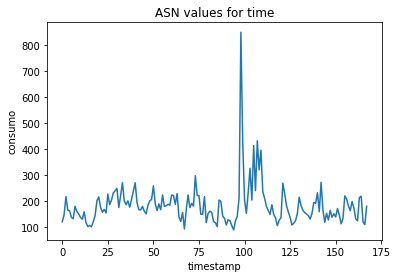

In [123]:
y_ans_val = [val.m_sum1 for val in j.select('m_sum1').orderBy('hour').collect()]
x_ts = [val.hour for val in j.select('hour').orderBy('hour').collect()]

plt.plot(x_ts, y_ans_val)

plt.ylabel('consumo')
plt.xlabel('timestamp')
plt.title('ASN values for time')

plt.show()

In [23]:
rddWithH1.sam.toPandas()

Py4JJavaError: An error occurred while calling o72.collectToPython.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:375)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:369)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.foreach(SparkPlan.scala:369)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:391)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:390)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$3586/296277120.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3532)
	at org.apache.spark.sql.Dataset$$Lambda$3503/1837096596.apply(Unknown Source)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3700)
	at org.apache.spark.sql.Dataset$$Lambda$1608/59652402.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1616/1809431950.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1609/183189189.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3698)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3529)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
